In [1]:
import investpy
from datetime import date, datetime
from fredapi import Fred
import eurostat
import quandl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

%matplotlib inline

C:\Users\tsaiy\anaconda3\lib\site-packages\pandasdmx\remote.py:11: RuntimeWarning: optional dependency requests_cache is not installed; cache options to Session() have no effect
  'to Session() have no effect', RuntimeWarning)


,Open,High,Low,Close,Currency
Date,,,,,
1979-12-27,1.5074,1.5074,1.5074,1.5074,USD
1979-12-28,1.5076,1.5076,1.5076,1.5076,USD
1979-12-31,1.5081,1.5081,1.5081,1.5081,USD
1980-01-02,1.5149,1.5149,1.5149,1.5149,USD
1980-01-03,1.5177,1.5177,1.5177,1.5177,USD


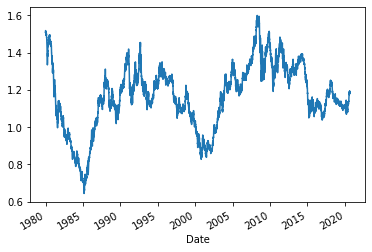

In [34]:
from_date = '27/12/1979'
freq = 'Daily'
today = datetime.now().strftime("%d/%m/%Y")

EUR = investpy.get_currency_cross_historical_data(currency_cross='EUR/USD', from_date = from_date,to_date = today, interval = freq)

display(EUR.head())
EUR['Close'].plot()

,Close,Change,Change_5d,Volatility,Month,Day
Date,,,,,,
1980-01-04,1.5129,-0.048880,0.020273,0.0,1,4
1980-01-07,1.5168,0.039715,0.033911,0.0,1,7
1980-01-08,1.5108,-0.061100,0.009952,0.0,1,8
1980-01-09,1.5161,0.053971,0.004423,0.0,1,9
1980-01-10,1.5133,-0.028513,-0.016218,0.0,1,10


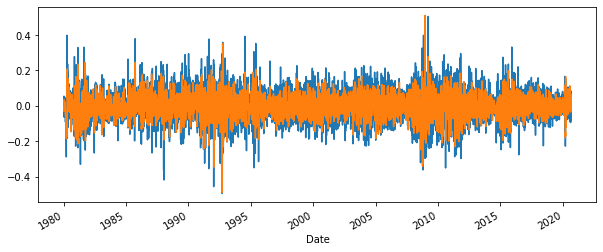

In [35]:
#當日報酬，並標準化
EUR['Change'] = EUR['Close'] - EUR['Close'].shift(1)
EUR['Change'] = EUR['Change']/(EUR['Change'].max() - EUR['Change'].min())

#過去5日漲跌，並標準化
EUR['Change_5d'] = EUR['Close'] - EUR['Close'].shift(5)
EUR['Change_5d'] = EUR['Change_5d']/(EUR['Change_5d'].max() - EUR['Change_5d'].min())


#股票震幅：(當日高 - 當日低)/ 昨日收
EUR['Volatility'] = (EUR['High'] - EUR['Low'])/EUR['Close'].shift(1) * 100
EUR['Volatility_5d'] = (EUR.loc[:,'High'] - EUR.loc[:,'Low'])/EUR.loc[:,'Close'].shift(5) * 100
EUR['Month'] = EUR.index.month
EUR['Day'] = EUR.index.day


EUR = EUR.drop(columns=['Open', 'High','Low','Currency'])
EUR = EUR.dropna()

display(EUR.head())
EUR['Change'].plot(figsize=(10,4))
EUR['Change_5d'].plot(figsize=(10,4))

In [36]:
#製作label，明天如果漲就設1，跌就設0
EUR['label'] = EUR['Change'].shift(-1)
EUR['label'] = EUR['label'].apply(lambda x:1 if x>0 else 0)
EUR.tail()

,Close,Change,Change_5d,Volatility,Month,Day,label
Date,,,,,,,
2020-08-27,1.1821,-0.008147,-0.014007,1.183532,8,27,1
2020-08-28,1.1903,0.083503,0.039808,0.930547,8,28,1
2020-08-31,1.1936,0.033605,0.054921,0.705704,8,31,0
2020-09-01,1.1910,-0.026477,0.028382,0.929960,9,1,0
2020-09-02,1.1833,-0.078411,0.001474,0.856423,9,2,0


# 資料前處理

In [26]:
#將資料分為train和test，以2010以前的資料作為train data
split_date = pd.Timestamp('01-01-2010')
train = EUR[:split_date]
test = EUR[split_date:]
x_train = train[['Close','Change','Volatility','Month','Day']]
y_train = train[['label']]

x_test = test[['Close','Change','Volatility','Month','Day']]
y_test = test[['label']]

# Ridge 和Lasso

In [37]:
#建模和訓練資料
from sklearn.linear_model import Ridge, Lasso
ridge = Ridge(alpha = 1.0)
lasso = Lasso(alpha = 1.0)
ridge.fit(x_train, y_train)
lasso.fit(x_train, y_train)

#模型精確度
print("Accurancy of Ridge:{}".format(ridge.score(x_train, y_train)))
print("Accurancy of Lasso:{}".format(ridge.score(x_train, y_train)))

Accurancy of Ridge:0.0015532494296668364
Accurancy of Lasso:0.0015532494296668364


# SVM

In [38]:
from sklearn.svm import SVC

svm = SVC(kernel = 'linear', probability = True)
svm.fit(x_train, y_train)

print("Accurancy of SVM:{}".format(svm.score(x_train, y_train)))

C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accurancy of SVM:0.5103013134174608


# RNN資料前處理

縮放後的train資料 
 [[0.91310389]
 [0.91085934]
 [0.90818726]
 ...
 [0.82909363]
 [0.83486533]
 [0.82727661]] 
 縮放後的train資料 
 [[0.91059527]
 [0.90415996]
 [0.8473914 ]
 [0.78441738]
 [0.73845093]
 [0.72787865]
 [0.72718915]
 [0.72971731]
 [0.72879798]
 [0.76120432]
 [0.70857274]
 [0.68076304]
 [0.70167778]
 [0.70052861]
 [0.70052861]
 [0.67455757]
 [0.65433234]
 [0.53114227]
 [0.43943921]
 [0.48770398]
 [0.41806481]
 [0.35049414]
 [0.38198115]
 [0.44495518]
 [0.44265686]
 [0.48540565]
 [0.50241324]
 [0.57044358]
 [0.56446794]
 [0.59687428]
 [0.65134452]
 [0.52884394]
 [0.51873133]
 [0.53183176]
 [0.56193978]
 [0.51229602]
 [0.59687428]
 [0.69868996]
 [0.76786946]
 [0.80257412]
 [0.81084808]
 [0.80464261]
 [0.80418295]
 [0.82348885]
 [0.74511607]
 [0.74373707]
 [0.64169157]
 [0.68122271]
 [0.63962308]
 [0.6276718 ]
 [0.61296254]
 [0.67294875]
 [0.56722593]
 [0.67248908]
 [0.72787865]
 [0.72672949]
 [0.72052402]
 [0.71202023]
 [0.74603539]
 [0.75844633]
 [0.81222707]
 [0.79498966]
 [0.85681453

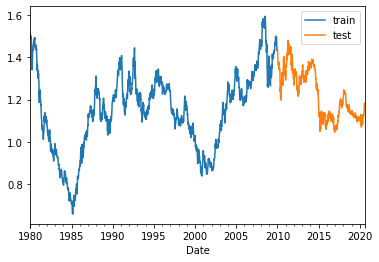

In [76]:
Price = EUR[["Close"]]  #兩個框框才會是dataframe，一個框框就變成series

split_date = pd.Timestamp('01-01-2010')
train = Price[:split_date]
test = Price[split_date:]

#將價格曲線畫出來
ax = train.plot()
test.plot(ax = ax)
plt.legend(['train','test'])

#將價格做縮放，範圍縮放至0~1
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.fit_transform(test)

print("縮放後的train資料",'\n',train_sc,'\n',"縮放後的train資料",'\n',test_sc)

# RNN

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error as MSE

# RNN資料前處理

In [83]:
#train data
x_train = train_sc[:-1]  #解釋變數，拿掉最後一補資料
y_train = train_sc[1:]  #預測變數，拿掉第一筆資料

#test data
x_test = test_sc[:-1]  #解釋變數，拿掉最後一補資料
y_test = test_sc[1:]  #預測變數，拿掉第一筆資料

In [84]:
#releases the global state: this helps avoid clutter from old models and layers, especially when memory is limited
K.clear_session()

#建一個Sequential Model(順序模型)，為多個網路層的線性堆疊
model = Sequential()

#由input_dim指定輸入尺寸
#激勵函數設為relu，為線性整流函數，https://mropengate.blogspot.com/2017/02/deep-learning-role-of-activation.html
model.add(Dense(12, input_dim = 1, activation = 'relu'))
model.add(Dense(1))
#optimizer(優化器)，adam結合AdaGrad和RMSProp的優點
#loss(損失函數)，為模型試圖最小化的目標函數，選擇MSE
model.compile(loss='mean_squared_error', optimizer='adam')
#verbose=1代表「詳細訊息模式」
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
#以1個樣本為一個batch進行迭代
history = model.fit(x_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Train on 1565 samples
Epoch 1/200
1565/1565 [==============================] - 1s 754us/sample - loss: 0.0382
Epoch 2/200
1565/1565 [==============================] - 1s 659us/sample - loss: 0.0033
Epoch 3/200
1565/1565 [==============================] - 1s 688us/sample - loss: 0.0017
Epoch 4/200
1565/1565 [==============================] - 1s 735us/sample - loss: 0.0011
Epoch 5/200
1565/1565 [==============================] - 1s 657us/sample - loss: 8.2886e-04
Epoch 6/200
1565/1565 [==============================] - 1s 677us/sample - loss: 7.2013e-04
Epoch 7/200
1565/1565 [==============================] - 1s 665us/sample - loss: 6.6087e-04s 
Epoch 8/200
1565/1565 [==============================] - 1s 702us/sample - loss: 6.2368e-04
Epoch 9/200
1565/1565 [==============================] - 1s 665us/sample - loss: 5.9870e-04
Epoch 10/200
1565/1565 [==============================] - 1s 670us/sample - loss: 5.8097e-04
Epoch 11/200
1565/1565 [==============================] - 1s 677us/samp

In [87]:
#將R-Squared包成一個函數
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [86]:
y_pred_test_ann = model.predict(x_test)
y_pred_train_ann = model.predict(x_train)

print("MSE of test data is {}".format(MSE(y_test, y_pred_test_ann)))
print("R2 of test data is {}".format(r2_score(y_test, y_pred_test_ann)))

print("MSE of train data is {}".format(MSE(y_train, y_pred_train_ann)))
print("R2 of train data is {}".format(r2_score(y_train, y_pred_train_ann)))

MSE of test data is 0.016294930652751477
R2 of test data is 0.7589394492647585
MSE of train data is 0.009239546729332004
R2 of train data is 0.7702061368020054


In [88]:
#儲存模型
model.save('ANN_NonShift.h5')

# LSTM資料前處理

In [89]:
#將資料變成三個維度
x_train_t = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_test_t = x_test.reshape(x_test.shape[0],1,x_test.shape[1])

In [90]:
#比較資料處理前後
print(x_train_t.shape)
print(x_train.shape)

(1565, 1, 1)
(1565, 1)


# LSTM

In [91]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, x_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(x_train_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(x_test_t)
y_train_pred_lstm = model_lstm.predict(x_train_t)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, x_train.shape[0], x_train.shape[1])))

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, x_test.shape[0], x_test.shape[1])))

Train on 1565 samples
Epoch 1/200
1565/1565 [==============================] - 2s 2ms/sample - loss: 0.0408
Epoch 2/200
1565/1565 [==============================] - 2s 1ms/sample - loss: 0.0056
Epoch 3/200
1565/1565 [==============================] - 2s 1ms/sample - loss: 0.0028
Epoch 4/200
1565/1565 [==============================] - 2s 1ms/sample - loss: 0.0015
Epoch 5/200
1565/1565 [==============================] - 2s 1ms/sample - loss: 9.2056e-04
Epoch 6/200
1565/1565 [==============================] - 2s 1ms/sample - loss: 7.0052e-04 0s - loss: 
Epoch 7/200
1565/1565 [==============================] - 2s 989us/sample - loss: 6.0183e-04
Epoch 8/200
1565/1565 [==============================] - 2s 985us/sample - loss: 5.5160e-04
Epoch 9/200
1565/1565 [==============================] - 2s 977us/sample - loss: 5.2273e-04
Epoch 10/200
1565/1565 [==============================] - 2s 1ms/sample - loss: 5.0455e-04 0
Epoch 11/200
1565/1565 [==============================] - 2s 1ms/sample -

1565/1565 [==============================] - 2s 974us/sample - loss: 4.5212e-04
Epoch 170/200
1565/1565 [==============================] - 2s 989us/sample - loss: 4.5211e-04
Epoch 171/200
1565/1565 [==============================] - 2s 982us/sample - loss: 4.5224e-04
Epoch 172/200
1565/1565 [==============================] - 2s 980us/sample - loss: 4.5222e-04
Epoch 173/200
1565/1565 [==============================] - 2s 1ms/sample - loss: 4.5209e-04
Epoch 174/200
1565/1565 [==============================] - 2s 1ms/sample - loss: 4.5213e-04
Epoch 175/200
1565/1565 [==============================] - 2s 1ms/sample - loss: 4.5217e-04
Epoch 176/200
1565/1565 [==============================] - 2s 991us/sample - loss: 4.5220e-04
Epoch 177/200
1565/1565 [==============================] - 2s 989us/sample - loss: 4.5224e-04
Epoch 178/200
1565/1565 [==============================] - 2s 999us/sample - loss: 4.5228e-04
Epoch 00178: early stopping
The R2 score on the Train set is:	0.814
The Adjusted

In [92]:
#儲存模型
model_lstm.save('LSTM_NonShift.h5')

# 模型預測

In [102]:
model_ann = load_model('ANN_EUR_Weekly.h5')
model_lstm = load_model('LSTM_EUR_Weekly.h5')

#Returns the loss value & metrics values for the model in test mode.
#損失值愈少愈好
ann_loss= model_ann.evaluate(x_test, y_test, batch_size=1)
lstm_loss = model_lstm.evaluate(x_test_t, y_test, batch_size=1)

print('ANN loss:{}'.format(ann_loss))
print('LSTM loss{}'.format(lstm_loss))
#print('ANN: %f'%ann_accur)
#print('LSTM: %f'%lstm_accur)

555/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

555/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

ANN loss:0.016294930625517883
LSTM loss0.011696505383685673


In [101]:
test, test1 = model_ann.evaluate(x_test, y_test)

555/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

TypeError: cannot unpack non-iterable numpy.float64 object

IndexError: invalid index to scalar variable.

In [79]:
y_pred_test_ANN = model_ann.predict(x_test)
y_pred_test_LSTM = model_lstm.predict(x_test_t)

In [82]:
col1 = pd.DataFrame(sc.inverse_transform(y_test), columns = ['True'])
col2 = pd.DataFrame(sc.inverse_transform(y_pred_test_ANN), columns=['ANN_prediction'])
col3 = pd.DataFrame(sc.inverse_transform(y_pred_test_LSTM), columns=['LSTM_prediction'])
#history.history是一個紀錄了連續迭代的訓練/驗證損失值和評估值的字典
col4 = pd.DataFrame(history.history['loss'], columns=['Loss_ANN'])
col5 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])

results = pd.concat([col1])
results = pd.concat([col1, col2, col3, col4, col5], axis=1)
results.to_excel('PredictionResults_ANN-LSTM_NonShift.xlsx')

# RNN視覺化

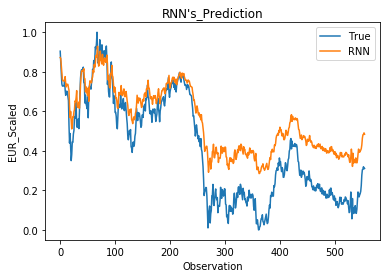

In [85]:
#https://keras.io/zh/visualization/
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ANN, label = 'RNN')
plt.title("RNN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('EUR_Scaled')
plt.legend()
plt.show()

# LSTM視覺化

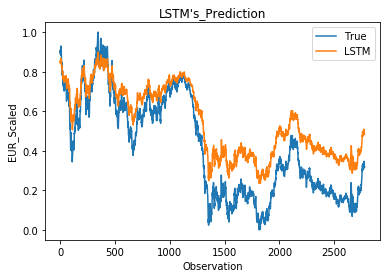

In [73]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label = 'LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('EUR_Scaled')
plt.legend()
plt.show()